In [51]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RBF Kernel

In [52]:
def rbf_kernel(x1, x2, gamma):
    # exp(-gamma * ||x1-x2||^2)
    diff = x1 - x2
    return np.exp(-gamma * np.dot(diff, diff))


Hàm clip alpha
SMO luôn yêu cầu:

L<= alpha <=H

Hàm này đảm bảo alpha không vượt biên

In [53]:
def clip(alpha, L, H):
    if alpha > H: return H
    if alpha < L: return L
    return alpha


In [54]:
class SVMRBF_SMO:
    def __init__(self, C=1.0, gamma=0.5, tol=1e-3, eps=1e-3,
                 max_passes=5, max_iter=200000, seed=42):
        self.C = float(C)
        self.gamma = float(gamma)
        self.tol = float(tol)
        self.eps = float(eps)
        self.max_passes = int(max_passes)
        self.max_iter = int(max_iter)
        self.rng = np.random.default_rng(seed)

        self.X = None
        self.y = None
        self.alphas = None
        self.b = 0.0
        self._K = None

    def _kernel(self, i, j):
        if self._K is not None:
            return self._K[i, j]
        return rbf_kernel(self.X[i], self.X[j], self.gamma)

    def _f(self, i):
        sv_mask = self.alphas > 0
        idx = np.where(sv_mask)[0]
        if idx.size == 0:
            return self.b
        s = 0.0
        for j in idx:
            s += self.alphas[j] * self.y[j] * self._kernel(j, i)
        return s + self.b

    def fit(self, X, y, use_kernel_cache=False):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        assert set(np.unique(y)).issubset({-1.0, 1.0}), "y phải là -1/+1"

        self.X = X
        self.y = y
        n = X.shape[0]
        self.alphas = np.zeros(n, dtype=np.float64)
        self.b = 0.0

        if use_kernel_cache:
            print("⚠️ Building full kernel matrix (O(n^2) memory)...")
            self._K = np.zeros((n, n), dtype=np.float64)
            for i in range(n):
                for j in range(i, n):
                    val = rbf_kernel(X[i], X[j], self.gamma)
                    self._K[i, j] = val
                    self._K[j, i] = val
        else:
            self._K = None

        passes = 0
        it = 0

        while passes < self.max_passes and it < self.max_iter:
            num_changed = 0

            for i in range(n):
                it += 1
                if it >= self.max_iter:
                    break

                Ei = self._f(i) - self.y[i]
                yi_fi = self.y[i] * (Ei + self.y[i])

                if ((yi_fi < 1 - self.tol and self.alphas[i] < self.C) or
                    (yi_fi > 1 + self.tol and self.alphas[i] > 0)):

                    j = i
                    while j == i:
                        j = self.rng.integers(0, n)

                    Ej = self._f(j) - self.y[j]
                    alpha_i_old = self.alphas[i]
                    alpha_j_old = self.alphas[j]

                    if self.y[i] != self.y[j]:
                        L = max(0.0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)
                    else:
                        L = max(0.0, alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)

                    if abs(L - H) < 1e-12:
                        continue

                    Kii = self._kernel(i, i)
                    Kjj = self._kernel(j, j)
                    Kij = self._kernel(i, j)
                    eta = 2.0 * Kij - Kii - Kjj
                    if eta >= 0:
                        continue

                    self.alphas[j] = alpha_j_old - (self.y[j] * (Ei - Ej)) / eta
                    self.alphas[j] = clip(self.alphas[j], L, H)

                    if abs(self.alphas[j] - alpha_j_old) < self.eps:
                        self.alphas[j] = alpha_j_old
                        continue

                    self.alphas[i] = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - self.alphas[j])

                    b_old = self.b
                    b1 = b_old - Ei - self.y[i] * (self.alphas[i] - alpha_i_old) * Kii - self.y[j] * (self.alphas[j] - alpha_j_old) * Kij
                    b2 = b_old - Ej - self.y[i] * (self.alphas[i] - alpha_i_old) * Kij - self.y[j] * (self.alphas[j] - alpha_j_old) * Kjj

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = 0.5 * (b1 + b2)

                    num_changed += 1

            passes = passes + 1 if num_changed == 0 else 0

        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=np.float64)
        sv_mask = self.alphas > 1e-8
        sv_idx = np.where(sv_mask)[0]
        if sv_idx.size == 0:
            return np.full(X.shape[0], self.b)

        scores = np.zeros(X.shape[0], dtype=np.float64)
        for t in range(X.shape[0]):
            s = 0.0
            for j in sv_idx:
                diff = self.X[j] - X[t]
                s += self.alphas[j] * self.y[j] * np.exp(-self.gamma * np.dot(diff, diff))
            scores[t] = s + self.b
        return scores

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, -1)

Tính toán các thông số cho TP,TN,FP,FN

In [55]:
def classification_report_binary(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-12)
    prec = TP / (TP + FP + 1e-12)
    rec = TP / (TP + FN + 1e-12)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)

    return acc, prec, rec, f1, TP, TN, FP, FN

In [56]:

def train_test_split_stratified(X, y, test_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    train_idx, test_idx = [], []

    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        rng.shuffle(idx)

        cut = int(len(idx) * (1 - test_ratio))
        train_idx.extend(idx[:cut])
        test_idx.extend(idx[cut:])

    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)

    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


In [65]:
import numpy as np
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/train_balanced.csv"
df = pd.read_csv(CSV_PATH)

# ✅ Tạo X, y từ df
y = np.where(df["HeartDisease"].values == 1, 1.0, -1.0)
X = df.drop(columns=["HeartDisease"]).values.astype(np.float64)

# ✅ Split 80/20 (stratified)
X_train, X_val, y_train, y_val = train_test_split_stratified(
    X, y, test_ratio=0.2, seed=42
)

print("Train size:", X_train.shape)
print("Validation size (20%):", X_val.shape)
print("Train pos/neg:", int(np.sum(y_train==1)), int(np.sum(y_train==-1)))
print("Val   pos/neg:", int(np.sum(y_val==1)), int(np.sum(y_val==-1)))


Train size: (32000, 22)
Validation size (20%): (8000, 22)
Train pos/neg: 16000 16000
Val   pos/neg: 4000 4000


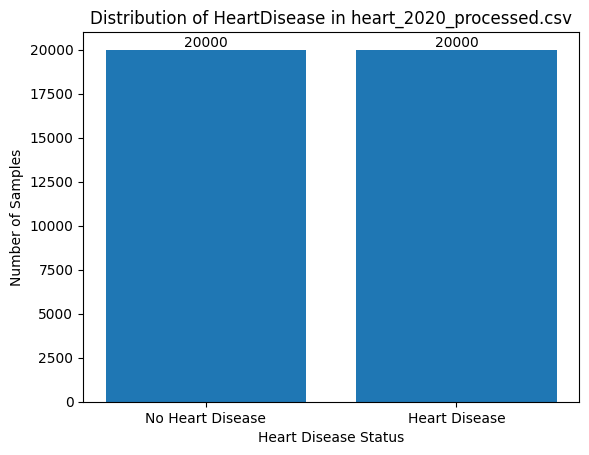

In [58]:
import matplotlib.pyplot as plt

counts = df["HeartDisease"].value_counts().sort_index()

plt.figure()
plt.bar(["No Heart Disease", "Heart Disease"], counts.values)

plt.title("Distribution of HeartDisease in heart_2020_processed.csv")
plt.xlabel("Heart Disease Status")
plt.ylabel("Number of Samples")

for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [60]:

y01 = df["HeartDisease"].values
y = np.where(y01 == 1, 1.0, -1.0)
X = df.drop(columns=["HeartDisease"]).values.astype(np.float64)

MAX_PER_CLASS = 4000
rng = np.random.default_rng(42)
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == -1)[0]
pos_pick = rng.choice(pos_idx, size=min(MAX_PER_CLASS, len(pos_idx)), replace=False)
neg_pick = rng.choice(neg_idx, size=min(MAX_PER_CLASS, len(neg_idx)), replace=False)
pick = np.concatenate([pos_pick, neg_pick])
rng.shuffle(pick)
X = X[pick]
y = y[pick]

print("Subset:", X.shape, "| Pos:", int(np.sum(y==1)), "| Neg:", int(np.sum(y==-1)))

Subset: (8000, 22) | Pos: 4000 | Neg: 4000


In [61]:
def stratified_k_fold(y, k=3, shuffle=True, seed=42):
    y = np.array(y)
    folds = [[] for _ in range(k)]
    rng = np.random.default_rng(seed)

    for cls in np.unique(y):
        idx_list = np.where(y == cls)[0]
        if shuffle:
            rng.shuffle(idx_list)
        split = np.array_split(idx_list, k)
        for i in range(k):
            folds[i].extend(split[i].tolist())

    folds = [np.array(fold, dtype=int) for fold in folds]
    return folds

In [62]:
def fit_standardizer(X_train):
    mu = X_train.mean(axis=0)
    sd = X_train.std(axis=0) + 1e-12
    return mu, sd

def transform_standardizer(X, mu, sd):
    return (X - mu) / sd

def cv_score_for_params_verbose(
    X, y, C, gamma, k=5, seed=42,
    tol=1e-3, eps=1e-3, max_passes=5, max_iter=5000
):
    folds = stratified_k_fold(y, k=k, shuffle=True, seed=seed)

    accs, precs, recs, f1s = [], [], [], []

    print(f"\n🔹 Start CV for C={C}, gamma={gamma}")

    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        X_tr, y_tr = X[train_idx], y[train_idx]
        X_va, y_va = X[val_idx], y[val_idx]

        # ===== Standardize theo từng fold =====
        mu = X_tr.mean(axis=0)
        sd = X_tr.std(axis=0) + 1e-12
        X_tr = (X_tr - mu) / sd
        X_va = (X_va - mu) / sd

        # ===== Train model =====
        model = SVMRBF_SMO(
            C=C, gamma=gamma,
            tol=tol, eps=eps,
            max_passes=max_passes,
            max_iter=max_iter,
            seed=seed
        )
        model.fit(X_tr, y_tr, use_kernel_cache=False)

        # ===== Evaluate =====
        pred = model.predict(X_va)
        acc, prec, rec, f1, TP, TN, FP, FN = classification_report_binary(y_va, pred)

        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)

        print(
            f"  Fold {i+1}/{k} | "
            f"Acc={acc:.4f} Prec={prec:.4f} "
            f"Rec={rec:.4f} F1={f1:.4f} "
            f"(TP={TP}, FP={FP}, FN={FN})"
        )

    mean_acc = np.mean(accs)
    mean_prec = np.mean(precs)
    mean_rec = np.mean(recs)
    mean_f1 = np.mean(f1s)

    print(
        f"➡️ CV MEAN | Acc={mean_acc:.4f} "
        f"Prec={mean_prec:.4f} Rec={mean_rec:.4f} "
        f"F1={mean_f1:.4f}"
    )

    return mean_acc, mean_prec, mean_rec, mean_f1


In [63]:
C_list = [0.1, 0.3, 1,]
gamma_list = [0.01, 0.03, 0.1]

best = None
results = []

for C in C_list:
    for gamma in gamma_list:
        mean_acc, mean_prec, mean_rec, mean_f1 = cv_score_for_params_verbose(
            X, y,
            C=C,
            gamma=gamma,
            k=5,
            seed=42,
            tol=1e-3,
            eps=1e-3,
            max_passes=5,
            max_iter=5000
        )

        results.append({
            "C": C,
            "gamma": gamma,
            "cv_acc": mean_acc,
            "cv_prec": mean_prec,
            "cv_rec": mean_rec,
            "cv_f1": mean_f1
        })

        print(
            f"✅ DONE C={C}, gamma={gamma} | "
            f"CV Acc={mean_acc:.4f} "
            f"Prec={mean_prec:.4f} "
            f"Rec={mean_rec:.4f} "
            f"F1={mean_f1:.4f}"
        )

        if (best is None) or (mean_f1 > best["cv_f1"]):
            best = results[-1]



🔹 Start CV for C=0.1, gamma=0.01
  Fold 1/5 | Acc=0.7394 Prec=0.8025 Rec=0.6350 F1=0.7090 (TP=508, FP=125, FN=292)
  Fold 2/5 | Acc=0.7125 Prec=0.8244 Rec=0.5400 F1=0.6526 (TP=432, FP=92, FN=368)
  Fold 3/5 | Acc=0.7544 Prec=0.7420 Rec=0.7800 F1=0.7605 (TP=624, FP=217, FN=176)
  Fold 4/5 | Acc=0.5175 Prec=1.0000 Rec=0.0350 F1=0.0676 (TP=28, FP=0, FN=772)
  Fold 5/5 | Acc=0.6250 Prec=0.8597 Rec=0.2987 F1=0.4434 (TP=239, FP=39, FN=561)
➡️ CV MEAN | Acc=0.6697 Prec=0.8457 Rec=0.4577 F1=0.5266
✅ DONE C=0.1, gamma=0.01 | CV Acc=0.6697 Prec=0.8457 Rec=0.4577 F1=0.5266

🔹 Start CV for C=0.1, gamma=0.03
  Fold 1/5 | Acc=0.6750 Prec=0.8382 Rec=0.4337 F1=0.5717 (TP=347, FP=67, FN=453)
  Fold 2/5 | Acc=0.7506 Prec=0.7485 Rec=0.7550 F1=0.7517 (TP=604, FP=203, FN=196)
  Fold 3/5 | Acc=0.6781 Prec=0.8467 Rec=0.4350 F1=0.5747 (TP=348, FP=63, FN=452)
  Fold 4/5 | Acc=0.7369 Prec=0.8542 Rec=0.5712 F1=0.6846 (TP=457, FP=78, FN=343)
  Fold 5/5 | Acc=0.6994 Prec=0.8097 Rec=0.5212 F1=0.6342 (TP=417, FP=98

In [77]:
mu, sd = fit_standardizer(X_train)

X_train_scaled = transform_standardizer(X_train, mu, sd)
X_val_scaled   = transform_standardizer(X_val,   mu, sd)

best_C = best["C"]
best_gamma = best["gamma"]

final_model = SVMRBF_SMO(
    C=best_C, gamma=best_gamma,
    tol=1e-3, eps=1e-3,
    max_passes=10, max_iter=5000,
    seed=42
)

final_model.fit(X_train_scaled, y_train, use_kernel_cache=False)

# ====== THRESHOLD Ở ĐÂY ======
scores_val = final_model.decision_function(X_val_scaled)
threshold = 1  # ví dụ
pred_val = np.where(scores_val >= threshold, 1.0, -1.0)
# ==============================

acc, prec, rec, f1, TP, TN, FP, FN = classification_report_binary(y_val, pred_val)

print("\n=== TEST SET 20% (INTERNAL, WITH THRESHOLD) ===")
print(f"Threshold : {threshold}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"TP={TP} TN={TN} FP={FP} FN={FN}")



=== TEST SET 20% (INTERNAL, WITH THRESHOLD) ===
Threshold : 1
Accuracy  : 0.7429
Precision : 0.7157
Recall    : 0.8057
F1-score  : 0.7581
TP=3223 TN=2720 FP=1280 FN=777


In [71]:
df_ext = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart_2020_processed.csv")

y_ext = np.where(df_ext["HeartDisease"].values == 1, 1.0, -1.0)
X_ext = df_ext.drop(columns=["HeartDisease"]).values.astype(np.float64)
X_ext_train_dummy, X_ext_test20, y_ext_train_dummy, y_ext_test20 = train_test_split_stratified(
    X_ext, y_ext, test_ratio=0.2, seed=42
)

print("External test (20%):", X_ext_test20.shape)


External test (20%): (63960, 22)


In [78]:
X_ext_test20_scaled = transform_standardizer(X_ext_test20, mu, sd)

scores_ext = final_model.decision_function(X_ext_test20_scaled)
threshold = 1.0
pred_ext20 = np.where(scores_ext >= threshold, 1.0, -1.0)

acc, prec, rec, f1, TP, TN, FP, FN = classification_report_binary(
    y_ext_test20, pred_ext20
)

print("\n=== EXTERNAL TEST (20% heart_2020_processed, WITH THRESHOLD) ===")
print(f"Threshold : {threshold}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"TP={TP} TN={TN} FP={FP} FN={FN}")



=== EXTERNAL TEST (20% heart_2020_processed) ===
Accuracy : 0.5169
Precision: 0.1426
Recall   : 0.9264
F1-score : 0.2471
TP=5072 TN=27987 FP=30498 FN=403


In [74]:
X_all_scaled = transform_standardizer(X, mu, sd)
svm_pred = final_model.predict(X_all_scaled)

svm_pred_01 = np.where(svm_pred == 1, 1, 0)
import pandas as pd

df_pred = pd.DataFrame({
    "svm_pred": svm_pred_01
})

df_pred.to_csv("svm_predictions_only.csv", index=False)
print("✅ Saved svm_predictions_only.csv")


✅ Saved svm_predictions_only.csv


In [75]:
import joblib
joblib.dump(
    {
        "model": final_model,
        "mu": mu,
        "sd": sd
    },
    "svm_rbf_model.joblib"
)


['svm_rbf_model.joblib']